In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10, 6)
import theano
import theano.tensor as T
import cPickle as pickle
import os
from plot_style import init_rc_params
init_rc_params()

paths = ['../../final_saved/mnist/basic/2.5e-05.pckl', 
         '../../final_saved/mnist/basic_cv/2.5e-06.pckl',
         '../../final_saved/mnist/full/1e-05_1e+09.pckl',
'../../final_saved/mnist/sgd/1e-07_10.0.pckl',
         '../../final_saved/mnist/lang/0.0005_1e+07.pckl']
labels = [u'1', u'2', u'3',
          u'4', u'5', u'Аппроксимация нормальным распределением']
lss = ['-','--', '-.',':','-2']
data_path = '../../../data/mini_mnist/'

ERROR (theano.gpuarray): pygpu was configured but could not be imported or is too old (version 0.6 or higher required)
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gpuarray/__init__.py", line 23, in <module>
    import pygpu.version
ImportError: No module named version


In [5]:
best = -99999999
best_i = ''
import glob
for f in glob.glob('../../final_saved/mnist/lang/*pckl'):
    with open(f, 'rb') as inp:
        data = pickle.load(inp)
        print f, data['validation'][-1]
        best = max(best,  data['validation'][-1])
        if best == data['validation'][-1]:
            best_i = f
print best_i

../../final_saved/mnist/lang/2.5e-05_1000.0.pckl -12647.1468928
../../final_saved/mnist/lang/5e-05_1e+09.pckl -12934.8838759
../../final_saved/mnist/lang/0.025_1000.0.pckl nan
../../final_saved/mnist/lang/0.00025_1e+07.pckl -12345.312405
../../final_saved/mnist/lang/5e-05_10.0.pckl -12732.1931414
../../final_saved/mnist/lang/0.001_1e+09.pckl -15344.3315716
../../final_saved/mnist/lang/0.005_10.0.pckl nan
../../final_saved/mnist/lang/0.01_1000.0.pckl nan
../../final_saved/mnist/lang/0.001_1000.0.pckl -19688.7946876
../../final_saved/mnist/lang/0.0005_10.0.pckl -11472.5664596
../../final_saved/mnist/lang/0.05_1e+09.pckl nan
../../final_saved/mnist/lang/0.0001_1e+09.pckl -13040.8907023
../../final_saved/mnist/lang/0.0005_1e+07.pckl -11400.3231357
../../final_saved/mnist/lang/0.05_10.0.pckl nan
../../final_saved/mnist/lang/0.025_100000.0.pckl nan
../../final_saved/mnist/lang/1e-05_10.0.pckl -12780.4244055
../../final_saved/mnist/lang/0.25_100000.0.pckl nan
../../final_saved/mnist/lang/0.1_

stability (noise in data)

In [5]:
best_i

'../../final_saved/mnist/full/2.5e-05_1000.0.pckl'

In [21]:
with open('../../final_saved/boston/basic_cv/2.5e-06.pckl', 'rb') as inp:
    data = pickle.load(inp)

In [16]:
test_x = np.load(os.path.join(data_path, 'train_x.npy'))
test_y = np.load(os.path.join(data_path, 'train_y.npy'))

test_y[test_y == 7] = 0
test_y[test_y == 9] = 1



train_x = test_x #for shape
label_id = -1 
for path,label, ls in zip(paths, labels, lss):
    label_id+=1.0
   
    print ls
    print label
    with open(path) as inp:
        data = pickle.load(inp)
    params = data['params'][-1]    
    param = T.vector()
    hidden_num = 50
    X = T.matrix()
    Y = T.vector()
    W1 = param[:train_x.shape[1]*hidden_num].reshape((test_x.shape[1],hidden_num))
    W2 = param[train_x.shape[1]*hidden_num:train_x.shape[1]*hidden_num+hidden_num*hidden_num].reshape((hidden_num, hidden_num))
    W3 = param[train_x.shape[1]*hidden_num+hidden_num*hidden_num:train_x.shape[1]*hidden_num+2*hidden_num**2].reshape((hidden_num,  hidden_num))
    W4 = param[train_x.shape[1]*hidden_num+2*hidden_num**2:train_x.shape[1]*hidden_num+2*hidden_num**2+hidden_num].reshape((hidden_num, 1))

    b1 = param[-hidden_num*3-1:-hidden_num*2-1]
    b2 = param[-hidden_num*2-1:-hidden_num-1]
    b3 = param[-hidden_num*1-1:-1]
    b4 = param[-1:]


    hidden1 =T.log(1+T.exp(T.dot(X, W1) + b1))#
    hidden2 =T.log(1+T.exp(T.dot(hidden1, W2) + b2))#
    hidden3 =T.log(1+T.exp(T.dot(hidden2, W3) + b3))#
    output = T.nnet.sigmoid(T.dot(hidden3, W4) + b4).flatten()
    
    output = T.clip(output, 0.001, 0.999)
    cost_ =-np.dot(Y, T.log(output)) - np.dot((1-Y) , T.log(1-output))
    cost = T.sum(cost_)*train_x.shape[0]/X.shape[0]
    
    
    monitor = theano.function([X,Y, param], cost, allow_input_downcast=True)
    results =[]
    results_std = []
    for noise_level in range(0,11):
        result = []
        noise = noise_level*1.0/10
        for p in params:
            p = np.array(p)
            result.append(monitor(test_x + np.random.randn(test_x.shape[0],     test_x.shape[1])*noise, test_y, p))
        results.append(np.mean(result))
        results_std.append(np.std(result))  
        if noise_level in [0,5,10]:
            print results[-1], results_std[-1]
    results = np.array(results)
    results_std = np.array(results_std)


KeyboardInterrupt: 

-
1
0.985252822779 0.00194135576475
0.933981345115 0.00458869449923
0.812665684831 0.011829392622
0.680471281296 0.0101374938932
-
--
2
0.984447717231 0.0023470605038
0.929563082965 0.00611601104209
0.808718703976 0.00880798314425
0.679960726559 0.00621265623824
--
-.
3
0.98617574865 0.00240371428542
0.932783505155 0.00613615315797
0.812881688758 0.0122557995037
0.678271968581 0.0135499633446
-.
:
4
0.914501718213 0.005046064123
0.857142857143 0.00638872792734
0.773588610702 0.00975729661173
0.673873343152 0.0120407849352
:
-2
5
0.979224349534 0.00389461076526
0.921826215022 0.00608148953752
0.800176730486 0.00825499336936
0.67471772214 0.0103181578049
normal
0.0289641629848 0.0
0.0832924234986 0.00411382918998
0.199721813124 0.00938760821866
[ 0.02896416  0.03136966  0.0381116   0.04786451  0.06357388  0.08329242
  0.10553101  0.1289478   0.15481918  0.17607593  0.19972181  0.22035673
  0.23560792  0.2539028   0.26974309  0.27982327  0.29211258  0.30751105
  0.31618393  0.3263623 ]


/usr/local/lib/python2.7/dist-packages/matplotlib/backends/backend_pdf.py:1122: UserWarning: 'FreeSerif.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
  warnings.warn(msg % os.path.basename(filename))


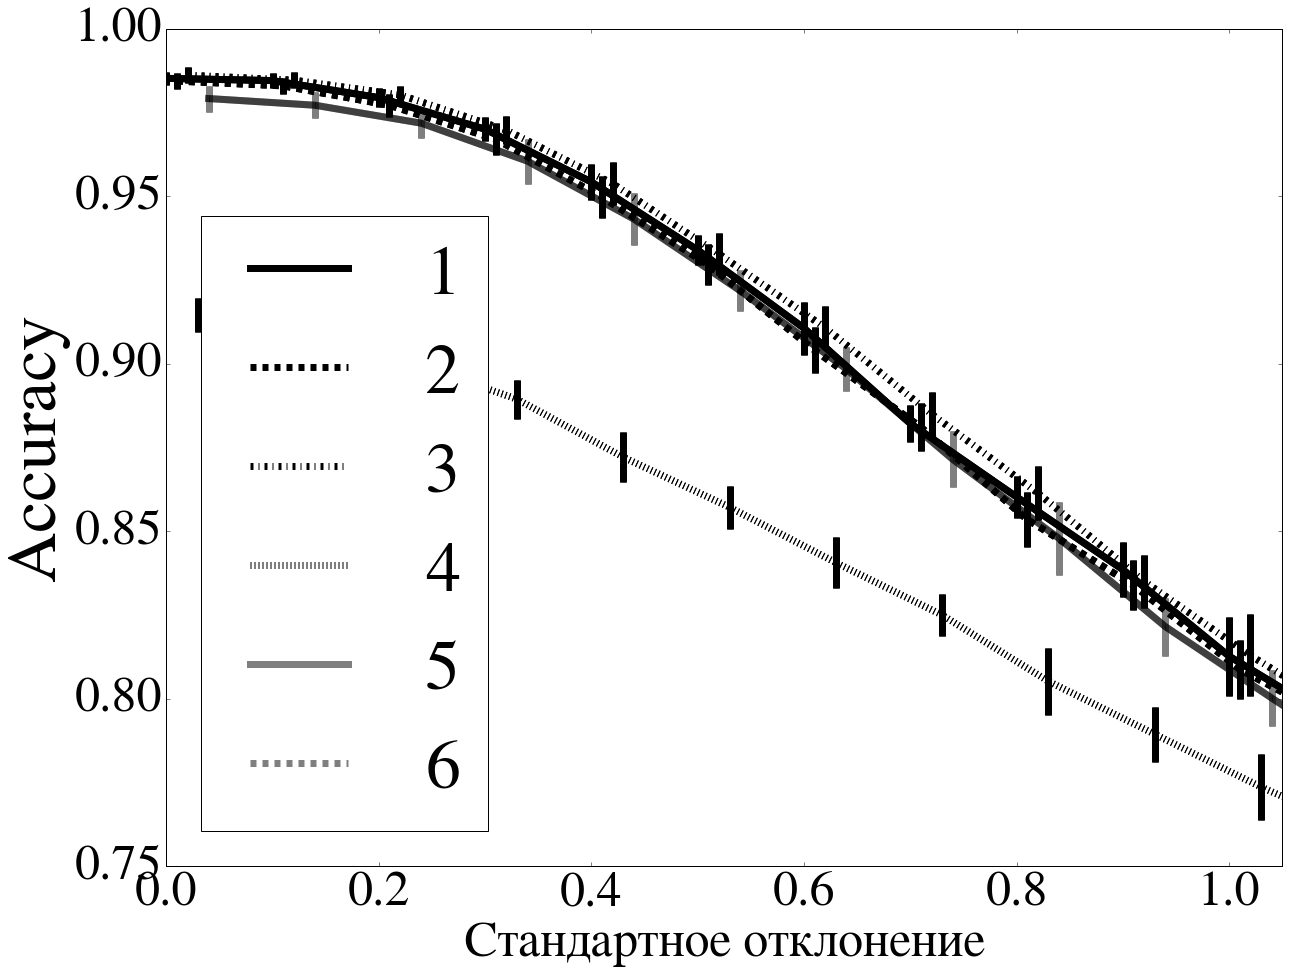

In [4]:
test_x = np.load(os.path.join(data_path, 'test_x.npy'))
test_y = np.load(os.path.join(data_path, 'test_y.npy'))

test_y[test_y == 7] = 0
test_y[test_y == 9] = 1



train_x = test_x #for shape
label_id = -1 
for path,label, ls in zip(paths, labels, lss):
    label_id+=1.0
   
    print ls
    print label
    with open(path) as inp:
        data = pickle.load(inp)
    params = data['params'][-1]    
    param = T.vector()
    hidden_num = 50
    X = T.matrix()
    Y = T.vector()
    W1 = param[:train_x.shape[1]*hidden_num].reshape((test_x.shape[1],hidden_num))
    W2 = param[train_x.shape[1]*hidden_num:train_x.shape[1]*hidden_num+hidden_num*hidden_num].reshape((hidden_num, hidden_num))
    W3 = param[train_x.shape[1]*hidden_num+hidden_num*hidden_num:train_x.shape[1]*hidden_num+2*hidden_num**2].reshape((hidden_num,  hidden_num))
    W4 = param[train_x.shape[1]*hidden_num+2*hidden_num**2:train_x.shape[1]*hidden_num+2*hidden_num**2+hidden_num].reshape((hidden_num, 1))

    b1 = param[-hidden_num*3-1:-hidden_num*2-1]
    b2 = param[-hidden_num*2-1:-hidden_num-1]
    b3 = param[-hidden_num*1-1:-1]
    b4 = param[-1:]


    hidden1 =T.log(1+T.exp(T.dot(X, W1) + b1))#
    hidden2 =T.log(1+T.exp(T.dot(hidden1, W2) + b2))#
    hidden3 =T.log(1+T.exp(T.dot(hidden2, W3) + b3))#
    output = T.nnet.sigmoid(T.dot(hidden3, W4) + b4).flatten()
    
    
    monitor = theano.function([X,param], output, allow_input_downcast=True)
    results =[]
    results_std = []
    for noise_level in range(0,20):
        result = []
        noise = noise_level*1.0/10
        for p in params:
            p = np.array(p)
            result.append(1-np.mean(np.not_equal(monitor(test_x + np.random.randn(test_x.shape[0],
                                                                                test_x.shape[1])*noise, p)>0.9, test_y)))
        results.append(np.mean(result))
        results_std.append(np.std(result))  
        if noise_level in [0,5,10, 19]:
            print results[-1], results_std[-1]
    results = np.array(results)
    results_std = np.array(results_std)
    #plt.fill_between([i*1.0/10 for i in range(len(results))], results-results_std, results+results_std, 
    #                 alpha=0.2, color='k')
    if ls!='-2':
        print ls
        plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=label,ls=ls, color='k', lw=7)
        plt.errorbar([(i*1.0+label_id/10)/10 for i in range(len(results))], results, xerr=0, yerr=results_std, color='k', ls=ls, lw=7)
    else:
        plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=label,ls='-', alpha=0.5, color='k', lw=7)
        plt.errorbar([(i*1.0+label_id/10)/10  for i in range(len(results))], results, xerr=0, yerr=results_std, color='k', alpha=0.5, lw=7)
    


print 'normal'
with open('../../final_saved/mnist/gaus/5e-05_10.0.pckl') as inp:
    data = pickle.load(inp)
params_all = data['params'][-1]   
results = []
results_std = []
for noise_level in range(0,20):
    result = []
    noise = noise_level*1.0/10
    for params in params_all:
        for _ in range(0,10):

            real_params = np.asanyarray(params[:len(params)/2]  )
            real_params = real_params + np.random.randn(len(params)/2)*np.exp(params[len(params)/2:])
            result.append(np.mean(np.not_equal(monitor(test_x + np.random.randn(test_x.shape[0],
                                                                                test_x.shape[1])*noise, p)>0.9, test_y)))
        
    results.append(np.mean(result))
    #print 'AAA', results[-1]
    results_std.append(np.std(result))
    if noise_level in [0, 5, 10]:
        print results[-1], results_std[-1]
        
results = np.array(results)
results_std = np.array(results_std)
print results
plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=u'6', color='k', alpha=0.5, lw=7, ls='--')
plt.errorbar([(i*1.0+label_id/10)/10 for i in range(len(results))], results, yerr=results_std,  color='k', alpha=0.5, lw=7, ls='--')


plt.xlim((0, 1.05))  
plt.ylim((0.75,1.0))
plt.legend(loc='best', fontsize=70)
plt.ylabel('Accuracy', fontsize=70)
plt.xlabel(u'Стандартное отклонение',fontsize=50)
plt.rcParams['figure.figsize'] = (20,20)
plt.tick_params(axis='both', which='major', labelsize=50)
plt.savefig('../../../doc/plots/mnist/acc_data.pdf')


In [3]:
with open('../../final_saved/mnist/gaus/2.5e-05_10.0.pckl', 'rb') as inp:
    data = pickle.load(inp)

stability (noise in params)

In [12]:
params = np.array(data['params'][-1][0])
train_x = np.load(os.path.join(data_path, 'train_x.npy'))
train_y = np.load(os.path.join(data_path, 'train_y.npy'))

train_y[train_y == 7] = 0
train_y[train_y == 9] = 1

learning curve

In [87]:
def sigmoid(x):
    return (1+np.exp(-x))**(-1)
mean = params[:params.shape[0]/2] 
hidden_num = 50
X = train_x
Y = train_y
param = mean+ np.random.randn(params.shape[0]/2)*np.exp(params[params.shape[0]/2:])
W1 = param[:train_x.shape[1]*hidden_num].reshape((train_x.shape[1],hidden_num))
W2 = param[train_x.shape[1]*hidden_num:train_x.shape[1]*hidden_num+hidden_num*hidden_num].reshape((hidden_num, hidden_num))
W3 = param[train_x.shape[1]*hidden_num+hidden_num*hidden_num:train_x.shape[1]*hidden_num+2*hidden_num**2].reshape((hidden_num,  hidden_num))
W4 = param[train_x.shape[1]*hidden_num+2*hidden_num**2:train_x.shape[1]*hidden_num+2*hidden_num**2+hidden_num].reshape((hidden_num, 1))

b1 = param[-hidden_num*3-1:-hidden_num*2-1]
b2 = param[-hidden_num*2-1:-hidden_num-1]
b3 = param[-hidden_num*1-1:-1]
b4 = param[-1:]


hidden1 =np.log(1+np.exp(np.dot(X, W1) + b1))#
hidden2 =np.log(1+np.exp(np.dot(hidden1, W2) + b2))#
hidden3 =np.log(1+np.exp(np.dot(hidden2, W3) + b3))#

output = sigmoid(np.dot(hidden3, W4) + b4).flatten()
output = np.maximum(0.001, np.minimum(output, 0.999))
cost_ =-np.dot(Y, np.log(output)) - np.dot((1-Y) , np.log(1-output))
cost = np.sum(cost_)*train_x.shape[0]/X.shape[0]

In [85]:
#cost 400 - 700


nan

r
Кросс-валидация
0.98617574865 0.00240371428542
0.931782032401 0.00750508168188
0.814688267059 0.0085832013942
0.680196367207 0.00896334026952
r
g
SGD
0.914501718213 0.005046064123
0.858792341679 0.00536316193763
0.772862052037 0.0113755100805
0.672498772705 0.0095952259105
g
b
Langevin
0.979224349534 0.00389461076526
0.920922925871 0.00645316541268
0.801845851743 0.0082682953493
0.674226804124 0.00979673612824
b
normal
0.971035837015 0.0
0.915529373261 0.00650280578911
0.800638193422 0.00891828391855
[ 0.97103584  0.96989036  0.96350843  0.95334642  0.93654066  0.91552937
  0.89271805  0.86854852  0.84807724  0.82263132  0.80063819  0.78306333
  0.76552119  0.74264441  0.73120602  0.72020946  0.70486009  0.69376534
  0.68167239  0.67569956]


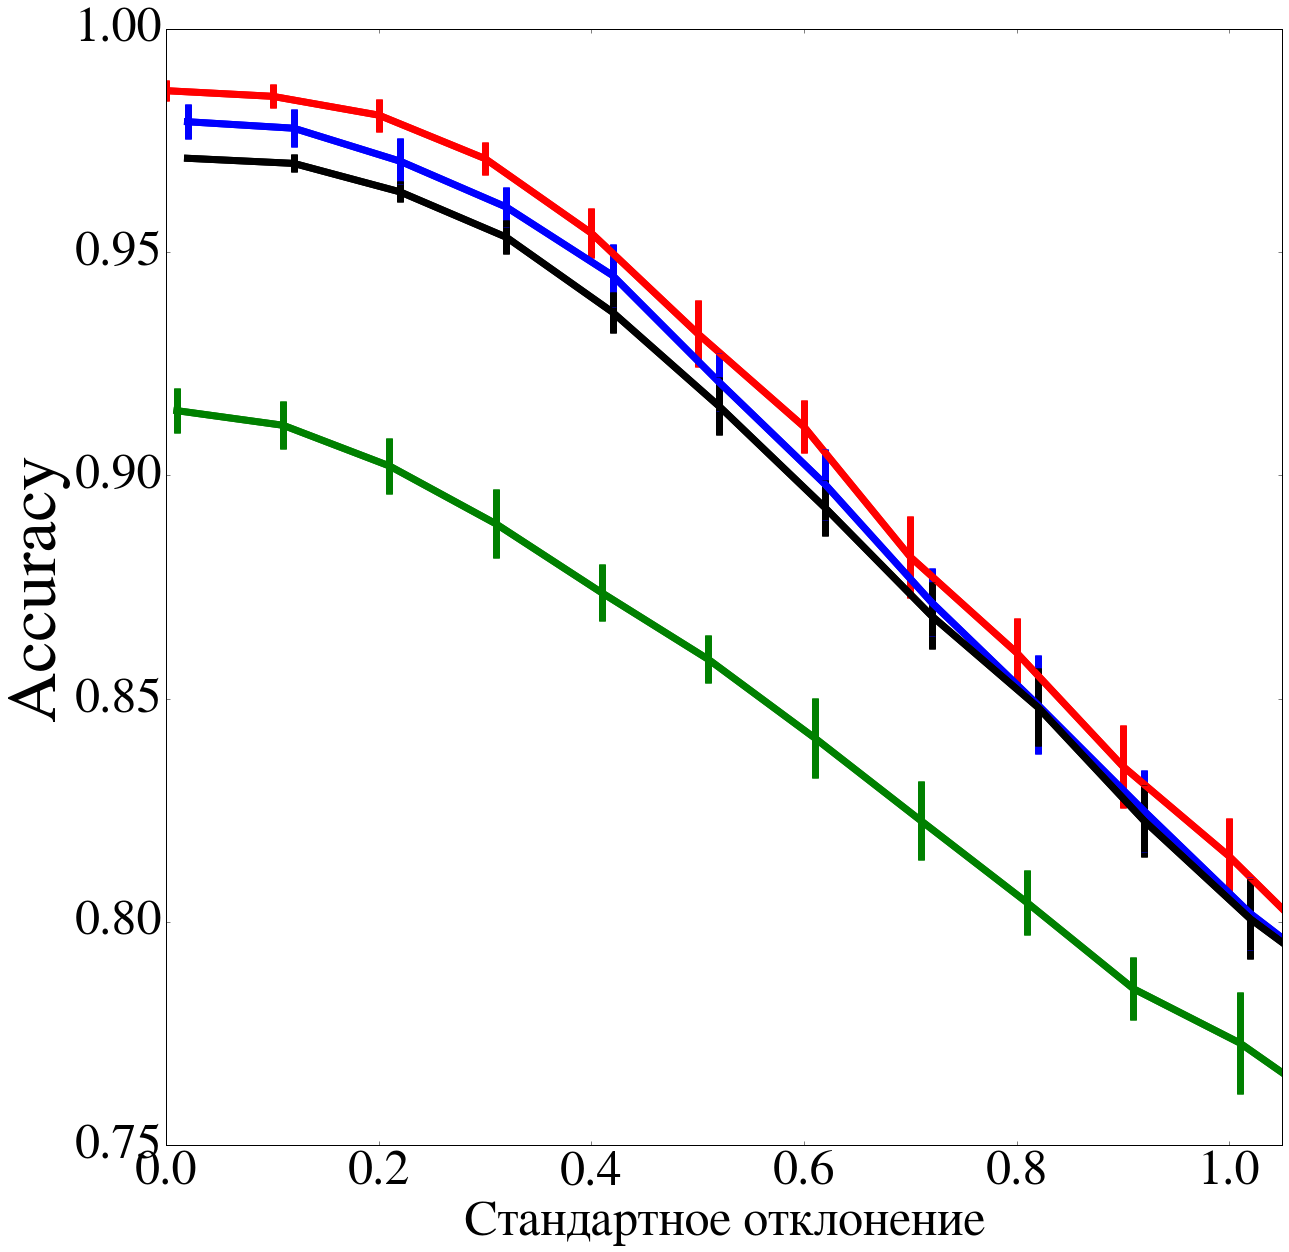

In [7]:
paths = [    '../../final_saved/mnist/full/1e-05_1e+09.pckl',
'../../final_saved/mnist/sgd/1e-07_10.0.pckl',
         '../../final_saved/mnist/lang/0.0005_1e+07.pckl']
labels = [u'Кросс-валидация',
          u'SGD', u'Langevin', u'Аппроксимация нормальным распределением']
lss = ['r','g', 'b','k']


test_x = np.load(os.path.join(data_path, 'test_x.npy'))
test_y = np.load(os.path.join(data_path, 'test_y.npy'))

test_y[test_y == 7] = 0
test_y[test_y == 9] = 1



train_x = test_x #for shape
label_id = -1 
for path,label, ls in zip(paths, labels, lss):
    label_id+=1.0
   
    print ls
    print label
    with open(path) as inp:
        data = pickle.load(inp)
    params = data['params'][-1]    
    param = T.vector()
    hidden_num = 50
    X = T.matrix()
    Y = T.vector()
    W1 = param[:train_x.shape[1]*hidden_num].reshape((test_x.shape[1],hidden_num))
    W2 = param[train_x.shape[1]*hidden_num:train_x.shape[1]*hidden_num+hidden_num*hidden_num].reshape((hidden_num, hidden_num))
    W3 = param[train_x.shape[1]*hidden_num+hidden_num*hidden_num:train_x.shape[1]*hidden_num+2*hidden_num**2].reshape((hidden_num,  hidden_num))
    W4 = param[train_x.shape[1]*hidden_num+2*hidden_num**2:train_x.shape[1]*hidden_num+2*hidden_num**2+hidden_num].reshape((hidden_num, 1))

    b1 = param[-hidden_num*3-1:-hidden_num*2-1]
    b2 = param[-hidden_num*2-1:-hidden_num-1]
    b3 = param[-hidden_num*1-1:-1]
    b4 = param[-1:]


    hidden1 =T.log(1+T.exp(T.dot(X, W1) + b1))#
    hidden2 =T.log(1+T.exp(T.dot(hidden1, W2) + b2))#
    hidden3 =T.log(1+T.exp(T.dot(hidden2, W3) + b3))#
    output = T.nnet.sigmoid(T.dot(hidden3, W4) + b4).flatten()
    
    
    monitor = theano.function([X,param], output, allow_input_downcast=True)
    results =[]
    results_std = []
    for noise_level in range(0,20):
        result = []
        noise = noise_level*1.0/10
        for p in params:
            p = np.array(p)
            result.append(1-np.mean(np.not_equal(monitor(test_x + np.random.randn(test_x.shape[0],
                                                                                test_x.shape[1])*noise, p)>0.9, test_y)))
        results.append(np.mean(result))
        results_std.append(np.std(result))  
        if noise_level in [0,5,10, 19]:
            print results[-1], results_std[-1]
    results = np.array(results)
    results_std = np.array(results_std)
    #plt.fill_between([i*1.0/10 for i in range(len(results))], results-results_std, results+results_std, 
    #                 alpha=0.2, color='k')
    print ls
    plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=label,color=ls, lw=7)
    plt.errorbar([(i*1.0+label_id/10)/10 for i in range(len(results))], results, xerr=0, yerr=results_std, color=ls, lw=7)
    


print 'normal'
with open('../../final_saved/mnist/gaus/1e-05_10.0.pckl') as inp:
    data = pickle.load(inp)
params_all = data['params'][-1]   
results = []
results_std = []
for noise_level in range(0,20):
    result = []
    noise = noise_level*1.0/10
    for params in params_all:
        for _ in range(0,10):

            real_params = np.asanyarray(params[:len(params)/2]  )
            real_params = real_params + np.random.randn(len(params)/2)*np.exp(params[len(params)/2:])
            result.append(1.0-np.mean(np.not_equal(monitor(test_x + np.random.randn(test_x.shape[0],
                                                                                test_x.shape[1])*noise, p)>0.9, test_y)))
        
    results.append(np.mean(result))
    #print 'AAA', results[-1]
    results_std.append(np.std(result))
    if noise_level in [0, 5, 10]:
        print results[-1], results_std[-1]
        
results = np.array(results)
results_std = np.array(results_std)
print results
plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=u'6', color='k',  lw=7)
plt.errorbar([(i*1.0+label_id/10)/10 for i in range(len(results))], results, yerr=results_std,  color='k', lw=7)


plt.xlim((0, 1.05))  
plt.ylim((0.75,1.0))
#plt.legend(loc='best', fontsize=70)
plt.ylabel('Accuracy', fontsize=70)
plt.xlabel(u'Стандартное отклонение',fontsize=50)
plt.rcParams['figure.figsize'] = (20,20)
plt.tick_params(axis='both', which='major', labelsize=50)
plt.savefig('../../../doc/plots/mnist/acc_data.pdf')

In [ ]:
paths = [ 
'../../final_saved/mnist/sgd/1e-05_1000.0.pckl']
labels = [u'Кросс-валидация',
          u'SGD', u'Langevin', u'Аппроксимация нормальным распределением']
lss = ['r','g', 'b','k']


test_x = np.load(os.path.join(data_path, 'test_x.npy'))
test_y = np.load(os.path.join(data_path, 'test_y.npy'))

test_y[test_y == 7] = 0
test_y[test_y == 9] = 1



train_x = test_x #for shape
label_id = -1 
for path,label, ls in zip(paths, labels, lss):
    label_id+=1.0
   
    print ls
    print label
    with open(path) as inp:
        data = pickle.load(inp)
    params = data['params'][-1]    
    param = T.vector()
    hidden_num = 50
    X = T.matrix()
    Y = T.vector()
    W1 = param[:train_x.shape[1]*hidden_num].reshape((test_x.shape[1],hidden_num))
    W2 = param[train_x.shape[1]*hidden_num:train_x.shape[1]*hidden_num+hidden_num*hidden_num].reshape((hidden_num, hidden_num))
    W3 = param[train_x.shape[1]*hidden_num+hidden_num*hidden_num:train_x.shape[1]*hidden_num+2*hidden_num**2].reshape((hidden_num,  hidden_num))
    W4 = param[train_x.shape[1]*hidden_num+2*hidden_num**2:train_x.shape[1]*hidden_num+2*hidden_num**2+hidden_num].reshape((hidden_num, 1))

    b1 = param[-hidden_num*3-1:-hidden_num*2-1]
    b2 = param[-hidden_num*2-1:-hidden_num-1]
    b3 = param[-hidden_num*1-1:-1]
    b4 = param[-1:]


    hidden1 =T.log(1+T.exp(T.dot(X, W1) + b1))#
    hidden2 =T.log(1+T.exp(T.dot(hidden1, W2) + b2))#
    hidden3 =T.log(1+T.exp(T.dot(hidden2, W3) + b3))#
    output = T.nnet.sigmoid(T.dot(hidden3, W4) + b4).flatten()
    
    
    monitor = theano.function([X,param], output, allow_input_downcast=True)
    results =[]
    results_std = []
    for noise_level in range(0,20):
        result = []
        noise = noise_level*1.0/10
        for p in params:
            p = np.array(p)
            result.append(1-np.mean(np.not_equal(monitor(test_x + np.random.randn(test_x.shape[0],
                                                                                test_x.shape[1])*noise, p)>0.9, test_y)))
        results.append(np.mean(result))
        results_std.append(np.std(result))  
        if noise_level in [0,5,10, 19]:
            print results[-1], results_std[-1]
    results = np.array(results)
    results_std = np.array(results_std)
    #plt.fill_between([i*1.0/10 for i in range(len(results))], results-results_std, results+results_std, 
    #                 alpha=0.2, color='k')
    print ls
    plt.plot([(i*1.0+label_id/10)/10  for i in range(len(results))], results, label=label,color=ls, lw=7)
    plt.errorbar([(i*1.0+label_id/10)/10 for i in range(len(results))], results, xerr=0, yerr=results_std, color=ls, lw=7)
  

plt.xlim((0, 1.05))  
plt.ylim((0.75,1.0))
#plt.legend(loc='best', fontsize=70)
plt.ylabel('Accuracy', fontsize=70)
plt.xlabel(u'Стандартное отклонение',fontsize=50)
plt.rcParams['figure.figsize'] = (20,20)
plt.tick_params(axis='both', which='major', labelsize=50)


r
Кросс-валидация
